# Image Classification for Autonomous Driving scenario

# Objectives

In this task, we create and train a neural network for image classification. In the task of image classification, we are given an image as input and asked to classify the image within one of a set number of classes. In this case, we will train a network to classify images as one of three labels: car, person, or neither. This information can be especially useful for a self-driving car seeking to identify dynamic objects.

# Setup Code
Lets first run some boilerplate code to set up our environment. This is needed each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. If prompted "Permit this notebook to access your Google Drive files?", select "Connect to Google Drive", and sign in to your Google account (the same account you used to store this notebook).

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### Path configuration
Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from this work:

```
['Data', 'utils.py', 'CarOrNot.ipynb',  'Image_classify.py']
```

If you are working on a local machine, just set `GOOGLE_DRIVE_PATH` to the path of your directory. 

In [2]:
import os

# Fill in the Google Drive path where you uploaded the notebook
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH = r"C:\Users\Lenovo\Downloads\SelfDriveSuite\Image Classification"
print(os.listdir(GOOGLE_DRIVE_PATH))

['CarOrNot.ipynb', 'Data', 'Image_classify.py', 'ImNet.pth', 'utils.py']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
# time.tzset()

In [5]:
# Imports
import numpy as np
import torch
import yaml

%matplotlib inline

Next we will check if a GPU is available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [25]:
from utils import *
from Imageclassify import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'Image_classify.py')

Welcome!


# Data Visualization

First, let's take a look at some examples of images from the dataset to get a feel for the data. Navigate to the `Train` folder within the `Data` folder to take a look at some of the example images our network will be tasked with labeling. Notice that the images are all of different sizes, which can be challenging for our network.

### PyTorch Imports and Parameters

We need some imports for PyTorch to run, which are found in the code cell below. We also need to set some hyper-parameters.



*   `batch_size` is the number of data examples within a mini-batch.
*   `lr` is the learning rate of the network.
*   `num_epochs` is the number of epochs, or times the network will train on each individual example.





In [8]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
batch_size = 64 #64# 32#4
lr = 0.0024#0.0003
num_epochs = 50

### Data Loader
Next, we will create data loaders for the training and validation set. Take a look in your Python file at the class `Cars` to how PyTorch datasets are created. Later in your final project you will need to create your own data loaders.

Remember how the images were all of different sizes? Fortunately, PyTorch includes special data transformation functions for us to transform each image to the same size. Check out the `transform_train()` function to see how this is accomplished.

In [10]:
trainset = Cars(os.path.join(GOOGLE_DRIVE_PATH, "Data", "Train"),
                transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=trainset.collate_fn)

valset = Cars(os.path.join(GOOGLE_DRIVE_PATH, "Data", "Val"),
                transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=valset.collate_fn)

classes = ('None', 'Car', 'Person')

Now that we have a data loader, we can take a look at some of the transformed images. We'll work on 32x32 pixel images, we will stick with the same. Unfortunately, at that resolution it is difficult to distinguish objects in some of the images. That's why the problem is even more challenging.

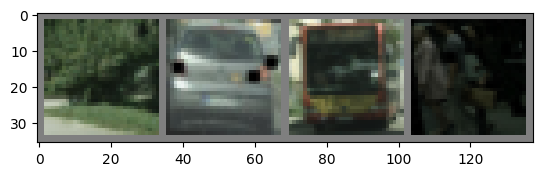

None  Car   Car   Person


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Lets define the training network

In [24]:
def train_net(net, trainloader, val_loader, device, num_epochs):
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      # Train
      net.train()
      running_loss = 0.0
      num_iters = 0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          num_iters += labels.shape[0]

      # print statistics
      print(f'epochs: {epoch + 1} loss: {running_loss / num_iters:.3f}')
      running_loss = 0.0
      num_iters = 0

      # Validate
      num_correct = 0
      num_total = 0
      net.eval()
      with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)

            # Check correct
            _, predicted = torch.max(outputs, 1)
            num_correct += torch.sum(predicted == labels)
            num_total += predicted.shape[0]

      # print statistics
      val_acc = 100 * num_correct / num_total
      print(f'epochs: {epoch + 1} Accuracy Val: {val_acc:.3f}')
      if val_acc>88.0:
         break
  print('Finished Training')

# Calling the Network
Now we call `ImNet()` neural network with whatever layers you want.

In [21]:
# Load the network
net = ImNet().to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

# Train the network
train_net(net, trainloader, val_loader, device, num_epochs)

# Save the weights
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'ImNet.pth')
torch.save(net.state_dict(), PATH)

epochs: 1 loss: 0.018
epochs: 1 Accuracy Val: 58.000
epochs: 2 loss: 0.014
epochs: 2 Accuracy Val: 48.000
epochs: 3 loss: 0.009
epochs: 3 Accuracy Val: 38.000
epochs: 4 loss: 0.007
epochs: 4 Accuracy Val: 34.000
epochs: 5 loss: 0.004
epochs: 5 Accuracy Val: 48.000
epochs: 6 loss: 0.004
epochs: 6 Accuracy Val: 44.000
epochs: 7 loss: 0.002
epochs: 7 Accuracy Val: 44.000
epochs: 8 loss: 0.003
epochs: 8 Accuracy Val: 60.000
epochs: 9 loss: 0.003
epochs: 9 Accuracy Val: 56.000
epochs: 10 loss: 0.003
epochs: 10 Accuracy Val: 48.000
epochs: 11 loss: 0.002
epochs: 11 Accuracy Val: 70.000
epochs: 12 loss: 0.002
epochs: 12 Accuracy Val: 58.000
epochs: 13 loss: 0.002
epochs: 13 Accuracy Val: 62.000
epochs: 14 loss: 0.001
epochs: 14 Accuracy Val: 78.000
epochs: 15 loss: 0.001
epochs: 15 Accuracy Val: 72.000
epochs: 16 loss: 0.001
epochs: 16 Accuracy Val: 86.000
epochs: 17 loss: 0.001
epochs: 17 Accuracy Val: 84.000
epochs: 18 loss: 0.001
epochs: 18 Accuracy Val: 88.000
epochs: 19 loss: 0.000
epoch

Run the following cell to visualize your saved weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


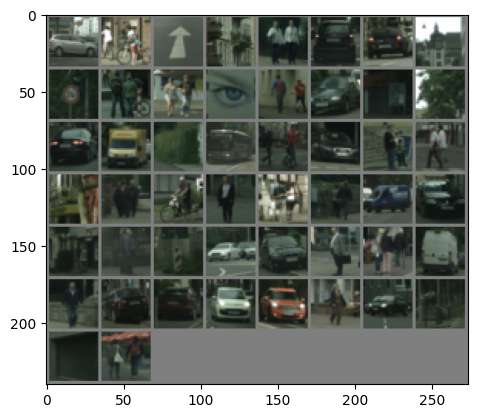

GroundTruth:  Car   Person None  None  Person Car   Car   None  None  Person Person None  Person Car   None  None  Car   Car   None  Car   Person Car   Person Person None  Person Person Person Person Person Car   Car   None  Person None  Car   Car   Person Person Car   Person Car   Car   Car   Car   Person Car   None  None  Person
Predicted:  Car   Person None  Person Car   Car   Car   None  Person Person Person None  Person Car   None  None  Car   Car   None  Car   Person Car   Person Person None  Person Person Person Person Person Car   Car   Person None  None  Car   Car   Person Person Car   Person Car   Car   Car   Car   Person Car   None  None  Person


In [22]:
dataiter = iter(val_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
total_val = 50
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(total_val)))

net = ImNet()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(total_val)))